In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

import os
from nonLinCorr import *

In [2]:
def flatten_and_mask_shots(shots, mask,):
    num_shots = shots.shape[0]
    size = shots.shape[1]*shots.shape[2]
    flat_mask = mask.reshape(size)
    flat_shots =  shots.reshape( (num_shots,size))*flat_mask
    
    return flat_shots[:,flat_mask]

def unflatten_shots(flat_shots,mask):
    num_shots = flat_shots.shape[0]
    shape = mask.shape
    flat_mask = mask.reshape(shape[0]*shape[1]
                            )
    shots = np.zeros( (num_shots,shape[0]*shape[1]), dtype = flat_shots.dtype)
    shots[:, flat_mask ] = flat_shots
    
    return shots.reshape( (num_shots,shape[0],shape[1]))

In [3]:
mask=np.load('/reg/d/psdm/cxi/cxilr6716/results/masks/basic_psana_mask.npy')

In [4]:
ls /reg/d/psdm/cxi/cxilr6716/results/flatfield_calibration/ave_int_statisitcs_basicMask/

run115_ave_int.h5  run75_ave_int.h5  run80_ave_int.h5  run84_ave_int.h5
run71_ave_int.h5   run76_ave_int.h5  run81_ave_int.h5  run85_ave_int.h5
run72_ave_int.h5   run77_ave_int.h5  run82_ave_int.h5
run73_ave_int.h5   run78_ave_int.h5  run83_ave_int.h5


In [11]:
ave_int_dir = '/reg/d/psdm/cxi/cxilr6716/results/flatfield_calibration/ave_int_statisitcs_basicMask/'
# run = 71
# f = h5py.File(os.path.join(ave_int_dir,'run%d_ave_int.h5'%run))
# print f.keys()
shots=[]
n_shots =[]
mean_ints=[]
all_mean_ints=[]
shots_err = []

runs=[71,72,73,75,76,77,78,80,81,82,83,84,85]
for rr in runs:
    f = h5py.File(os.path.join(ave_int_dir,'run%d_ave_int.h5'%rr))
    ss=f['ave_flat_shots'].value
    n_shots.append(f['num_shots_per_bin'].value)
    shots.append(ss)
    mean_ints.append(ss.mean(-1))
    
    shots_err.append(f['ave_flat_shots_err'].value)
    
    

In [13]:
n_shots_in_bag

array([ 22922.,   2488.,   3344.,  10907.,   5421.,   6032.,   6500.,
         2734.,    836.,   1455.,   2080.,   3171.,   3417.,   1860.,
         1212.,   1021.,    993.,    973.,   1491.,   1421.,   1541.,
         1387.,   1414.,   1595.,   1826.,   2897.,   2126.,   1957.,
         1891.,   2328.,   1505.,   1335.,   1031.,    939.,    647.,
          547.,    415.,    362.,    293.,    253.,    238.,    188.,
          177.,    284.,    105.])

In [12]:
all_mean_ints = np.concatenate(mean_ints)
all_mean_ints.min(),all_mean_ints.max()
new_int_bins=np.linspace(0,126,60)
bags_of_shots=np.zeros((new_int_bins.size,shots[0].shape[-1]))
bags_of_shots_err=np.zeros((new_int_bins.size,shots[0].shape[-1]))
n_shots_in_bag = np.zeros_like(new_int_bins)

for idx,int_list in enumerate (mean_ints):
    labels = np.digitize(int_list,new_int_bins)
    for ll in np.unique(labels):
        nn= np.sum(n_shots[idx][labels==ll])
        n_shots_in_bag[ll]+=nn
        
        ss=np.sum(shots[idx][labels==ll]*n_shots[idx][labels==ll][:,None],axis=0)
        bags_of_shots[ll]+=ss
        
        ss_err=np.sum((shots_err[idx][labels==ll]**2)*n_shots[idx][labels==ll][:,None],axis=0)
        bags_of_shots_err[ll]+=ss_err
# % only those with         
select = n_shots_in_bag>100
bags_of_shots=bags_of_shots[select]
n_shots_in_bag=n_shots_in_bag[select]
bags_of_shots/=n_shots_in_bag[:,None]

bags_of_shots_err=bags_of_shots_err[select]
bags_of_shots_err= np.sqrt(bags_of_shots_err/n_shots_in_bag[:,None])

In [14]:
bags_of_shots.shape

(45, 2239810)

(0.0, 1500)

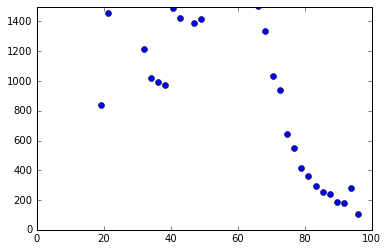

In [15]:
plt.plot(new_int_bins[select],n_shots_in_bag,'o')
plt.ylim(0.,1500)

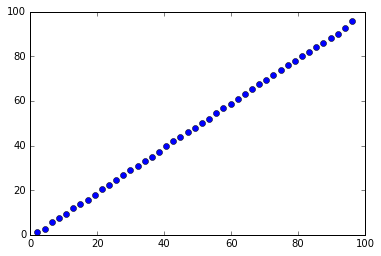

In [16]:
plt.plot(new_int_bins[select],bags_of_shots.mean(-1),'o')

In [48]:
n_shots_in_bag>100

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False], dtype=bool)

In [18]:
all_shots=np.concatenate(shots)
all_shots.shape

(562, 2239810)

In [19]:
all_shots.shape

(562, 2239810)

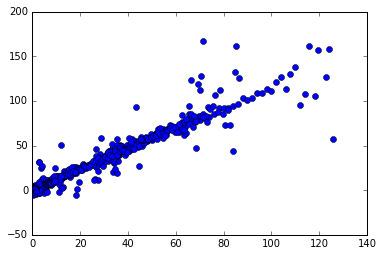

In [20]:
ind=20
plt.plot(all_mean_ints,all_shots[:,ind],'o')

In [21]:
bags_mean_int=bags_of_shots.mean(-1)
gn = bags_mean_int[:,None]/bags_of_shots

<Container object of 3 artists>

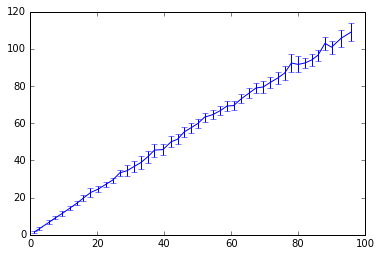

In [24]:
ind=20
plt.errorbar(bags_mean_int,bags_of_shots[:,ind],yerr=bags_of_shots_err[:,ind])

# plt.plot(all_mean_ints,all_shots[:,ind],'.', alpha=0.2)
# ind=14353
# plt.plot(bags_mean_int,bags_of_shots[:,ind],'o')

In [26]:
# f_coefs=h5py.File('/reg/d/psdm/cxi/cxilr6716/results/flatfield_calibration/copper_cali_coefs.h5','a')
# f_coefs.create_dataset('cali_fit_std',data=bags_of_shots_err)
# f_coefs.close()


(0.6, 1.2)

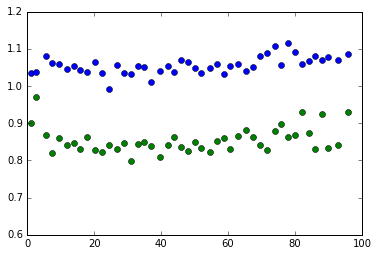

In [35]:
# Intensity dependence of gain map for different pixels
ind = 124565
plt.plot(bags_mean_int,gn[:,ind],'o')
ind = 124
plt.plot(bags_mean_int,gn[:,ind],'o')
plt.ylim(0.6,1.2)

In [101]:
# f_out=h5py.File('/reg/d/psdm/cxi/cxilr6716/results/flatfield_calibration/copper_cali_coefs.h5','w')

In [102]:

    
f_out.create_dataset('test1_shots', data=all_shots[100:105])
f_out.create_dataset('cali_fit_shots', data=bags_of_shots)
f_out.create_dataset('cali_fit_nShots',data=n_shots_in_bag)

degree = 10
for dd in [5,10,15,20]:
    print ("poly degree: %d"%dd)
    cn = getCorrectionFunc2(dmat = gn, i = bags_mean_int,order=dd)
    c = lambda(i): polyVal(cn,i)
    f_out.create_dataset('coefs_%d'%dd,data=cn)
    
    print("cali test1")
    calibrated_curves = c(all_mean_ints[100:105])
    calibrated_shots = all_shots[100:105]*calibrated_curves
    
    f_out.create_dataset('test1_cali_%d'%dd, data=calibrated_shots)
    print("cali test2")
    calibrated_curves = c(bags_mean_int)
    calibrated_shots = bags_of_shots*calibrated_curves
    
    f_out.create_dataset('test2_cali_%d'%dd, data=calibrated_shots)


poly degree: 5
cali test1
cali test2
poly degree: 10
cali test1
cali test2
poly degree: 15
cali test1
cali test2
poly degree: 20
cali test1
cali test2


In [103]:
f_out.close()

In [97]:
f=h5py.File('/reg/d/psdm/cxi/cxilr6716/results/flatfield_calibration/copper_cali_coefs.h5','r')

In [98]:
f.keys()

[u'cali_fit_nShots',
 u'cali_fit_shots',
 u'coefs_10',
 u'coefs_15',
 u'coefs_20',
 u'coefs_5',
 u'test1_cali_10',
 u'test1_cali_15',
 u'test1_cali_20',
 u'test1_cali_5',
 u'test1_shots',
 u'test2_cali_10',
 u'test2_cali_15',
 u'test2_cali_20',
 u'test2_cali_5']

In [75]:
calibrated_curves = c(all_mean_ints[100:105])
calibrated_shots = all_shots[100:105]*calibrated_curves

# calibrated_curves = c(bags_mean_int)
# calibrated_shots = bags_of_shots*calibrated_curves

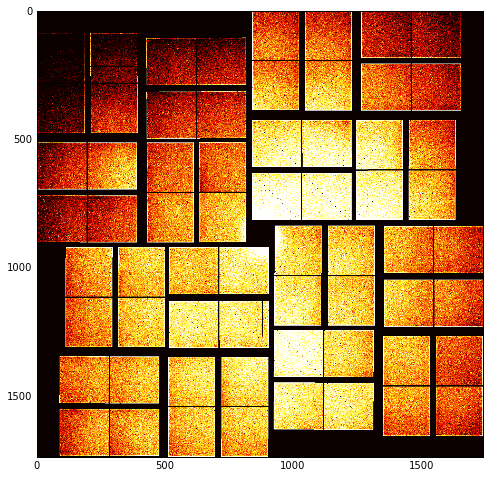

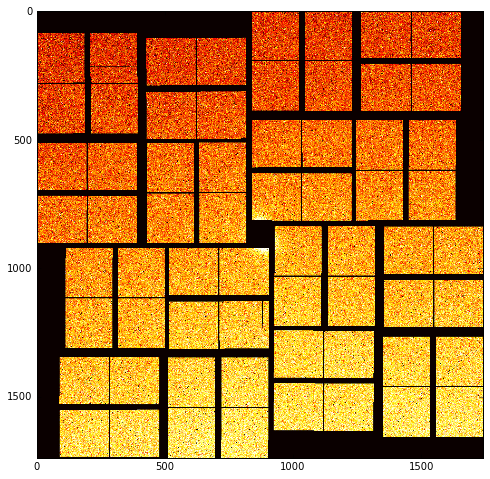

In [79]:
plt.figure(figsize=[8,8])
plt.imshow( unflatten_shots(all_shots[102][None,:],mask)[0], 
         aspect=1, cmap='hot',vmin=60,vmax=70)
# plt.colorbar()


plt.figure(figsize=[8,8])
plt.imshow( unflatten_shots(calibrated_shots[2][None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=60,vmax=70)

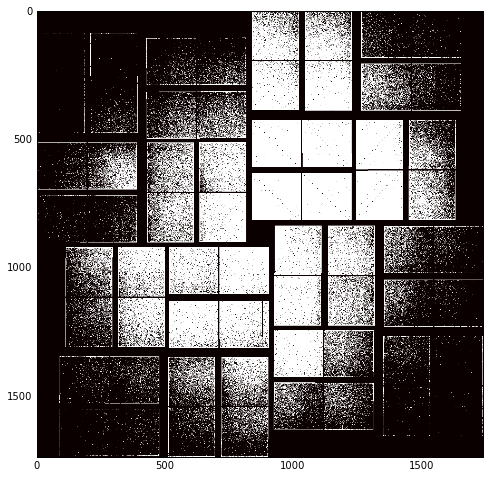

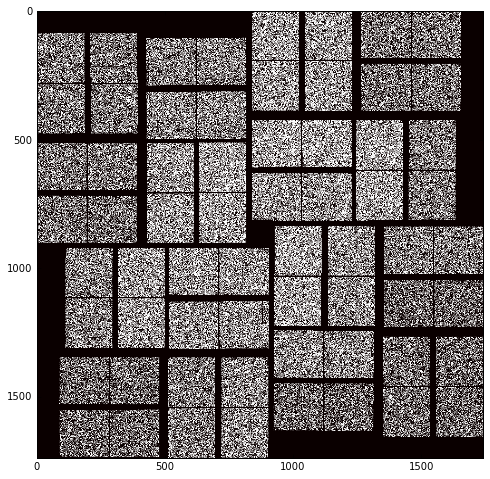

In [107]:
ii=22
threshold=48
plt.figure(figsize=[8,8])
plt.imshow( unflatten_shots(bags_of_shots[ii][None,:],mask)[0]>threshold, 
         aspect=1, cmap='hot')#,vmin=12,vmax=24)
# plt.colorbar()


plt.figure(figsize=[8,8])
plt.imshow( unflatten_shots(calibrated_shots[ii][None,:],mask)[0]>threshold, 
         aspect='auto', cmap='hot')#,vmin=10,vmax=18)

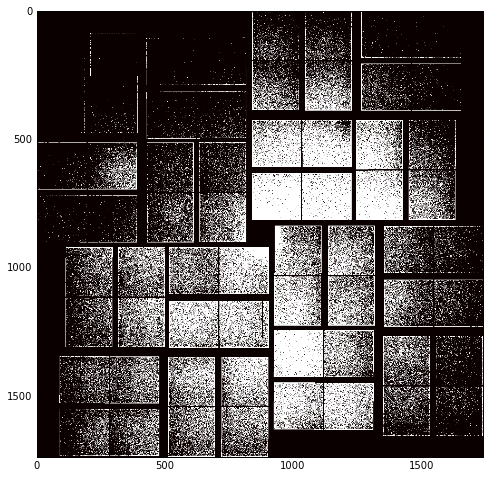

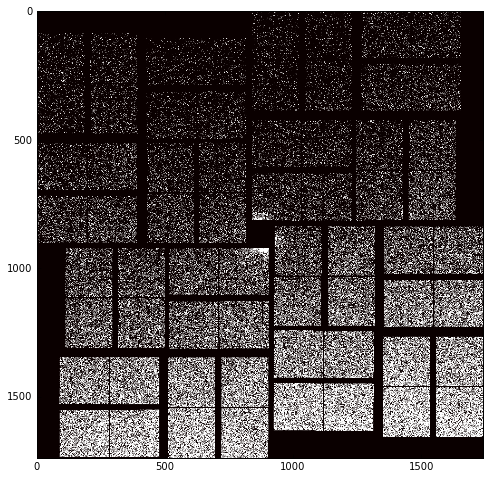